# Analysis using the sacred runs

In [1]:
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts

First, we need to load all the runs in memory, so we can index and filter them depending on the parameters.

In [2]:
BASE_DIR = '../sacred_runs/'
runs = {}
runs_filenames = glob.glob(BASE_DIR + '*/config.json')
run_extractor = re.compile(BASE_DIR + '([0-9]+)/config.json')
for r in runs_filenames:
    try:
        run_number = int(run_extractor.match(r).group(1))
        runs[run_number] = {}
        runs[run_number]['config'] = json.load(open(BASE_DIR + str(run_number) + '/config.json'))
        runs[run_number]['run'] = json.load(open(BASE_DIR + str(run_number) + '/run.json'))
        runs[run_number]['metrics'] = json.load(open(BASE_DIR + str(run_number) + '/metrics.json'))
    except:
        del runs[run_number]

We can also create a pandas dataframe to show in a table all the runs and parameters.

In [3]:
config_pd = pd.DataFrame.from_dict({rk: r['config'] for rk, r in runs.items()}, orient='index')
run_pd = pd.DataFrame.from_dict({rk: r['run'] for rk, r in runs.items()}, orient='index')
run_df = pd.concat([config_pd, run_pd], axis=1)

Now, all the runs are inside the runs dict, with their relative config, run and metrics file. We can now extract information about them. To make our life easier, we create a simple function to filter the runs directly.

In [4]:
def filter_runs(query):
    keys = list(runs.keys())
    for key, value in query.items():
        # Check if the still unfiltered runs have the specified parameter. If not, remove them
        _keys = []
        for run_key in keys:
            obj = runs[run_key]
            # Dot notation at any level
            for qk in key.split('.'):
                obj = obj[qk]
            # Check if it matches value
            if obj == value:
                _keys.append(run_key)
        keys = _keys
    # Now create a filtered object only with the selected runs
    _runs = {key: runs[key] for key in keys}
    return _runs

**TODO:** this should be inserted in a class

Also, we need to replicate the matplotlib function to extract mean and confidence interval from many runs.

In [5]:
def plot_mean_ci(my_runs, metric, conf=0.95):
    # Extract the metric
    metric_matrix = np.array([value['metrics'][metric]['values'] for key, value in my_runs.items()])
    # Get mean and ci
    mean = np.mean(metric_matrix, axis=0)
    std = np.std(metric_matrix, axis=0)
    interval = sts.t.interval(conf, metric_matrix.shape[0]-1, loc=mean, scale=std/np.sqrt(metric_matrix.shape[0]))
    fig = plt.figure(figsize=(16,4))
    plt.plot(mean)
    plt.fill_between(range(len(mean)),interval[0], interval[1], alpha=0.3)
    plt.show();
    
def plot_all(my_runs, metric):
    # Extract the metric
    metric_matrix = np.array([value['metrics'][metric]['values'] for key, value in my_runs.items()])
    fig = plt.figure(figsize=(16,4))
    for i in range(metric_matrix.shape[0]):
        plt.plot(metric_matrix[i])
    plt.show();

## Inverted-Pendulum POIS baseline
We first start by plotting the baseline.

Extracted 5 experiments.


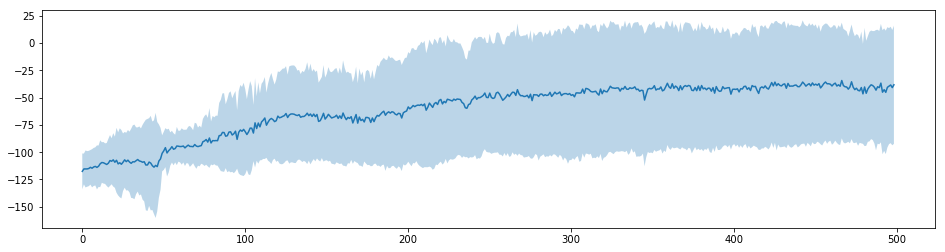

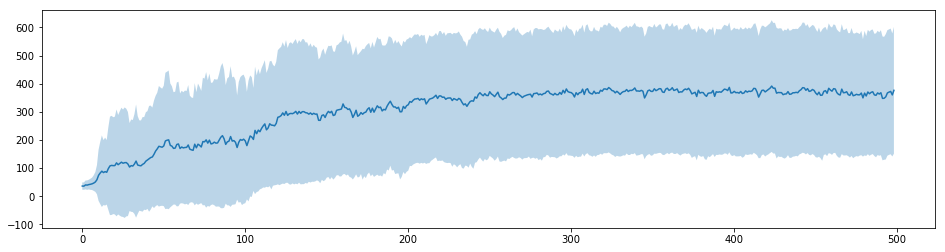

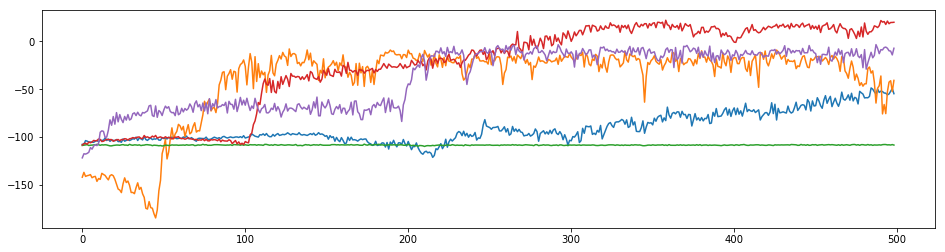

In [9]:
# Define the baseline params
baseline_runs = filter_runs({
    'config.entropy': '0:0',
    'config.center': True,
    'config.env': 'inverted-pendulum',
    'config.iw_method': 'is',
    'config.iw_norm': 'none',
    'config.delta': 0.9,
    'config.bound': 'max-d2',
    'config.gamma': 0.99,
    'config.clipping': False,
    'config.njobs': 1,
    'config.natural': False,
    'config.policy': 'linear',
    'config.num_episodes': 100,
    'run.status': 'COMPLETED'
})
# Extract the metrics we are interested in, plotting the mean with confidence bound
print("Extracted", len(baseline_runs.keys()), 'experiments.')
if len(baseline_runs.keys()) > 0:
    plot_mean_ci(baseline_runs, 'EpRewMean')
    plot_mean_ci(baseline_runs, 'EpLenMean')
    plot_all(baseline_runs, 'EpRewMean')

In [17]:
# Define the baseline params
exp_runs = filter_runs({
    'config.entropy': 'step:10.0:100',
    'config.center': True,
    'config.env': 'inverted-pendulum',
    'config.iw_method': 'pdis',
    'config.iw_norm': 'none',
    'config.delta': 0.9,
    'config.bound': 'pdis-d2',
    'config.gamma': 0.99,
    'config.clipping': False,
    'config.njobs': 1,
    'config.natural': False,
    'config.policy': 'linear',
    'config.num_episodes': 100,
    'run.status': 'COMPLETED',
    'run.host.hostname': 'nash'
})
# Extract the metrics we are interested in, plotting the mean with confidence bound
print("Extracted", len(exp_runs.keys()), 'experiments.')
if len(exp_runs.keys()) > 0:
    plot_mean_ci(exp_runs, 'EpRewMean')
    plot_mean_ci(exp_runs, 'EpLenMean')
    plot_all(exp_runs, 'EpRewMean')

Extracted 4 experiments.


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [14]:
run_df[(run_df['status'] == 'COMPLETED')&(run_df['iw_method'] == 'pdis')&(run_df['entropy'] == 'step:10.0:100')].iloc[0]['host']

{'ENV': {},
 'cpu': 'Intel(R) Xeon(R) CPU E5-4610 v2 @ 2.30GHz',
 'hostname': 'bellman',
 'os': ['Linux', 'Linux-4.4.0-130-generic-x86_64-with-Ubuntu-16.04-xenial'],
 'python_version': '3.5.2'}